In [1]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random
import matplotlib as mpl
import os
import gc
# import pandas as pd
import csv
from numpy import *
from datetime import date
import time
import builtins
plt.rcParams['figure.dpi'] = 100

/home/apa2237/miniconda3/envs/complor/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
amino_acid = ['A', 'V', 'F', 'I', 'L','D','E','K','S','T','Y','C','N','Q', 'P','M', 'R', 'H', 'W', 'G']# X is the uncommon amino acid, so total length is 6
hydro = [1.8, 4.2, 2.8, 4.5, 3.8, -3.5, -3.5, -3.9, -0.8, -0.7, -1.3, 2.5, -3.5, -3.5, -1.6, 1.9, -4.5, -3.2, -0.9, -0.4]
hydro = np.abs(hydro)
num_aa = len(amino_acid)
print(f'Total numnber of amino acids are {len(amino_acid)}')

Total numnber of amino acids are 20


## Load the Importance, One-hot encoding and sequence length

In [3]:
ohe = np.load('./data/x_test.npy', allow_pickle=True)
seq_len = np.load('./data/len_test.npy', allow_pickle=True)
imp = np.load('./data/test_importance.npy', allow_pickle=True)
prop = np.load('./data/y_test.npy', allow_pickle=True)

In [4]:
dict_score = {}
for i in range(num_aa):
    dict_score[i] = []
    
score = np.zeros((len(amino_acid),))
count = np.zeros((len(amino_acid),))

N = ohe.shape[0]
for i in range(N):
    if prop[i] != 0:
        l = int(seq_len[i])
        x = np.argmax(ohe[i,0:l,:],axis=-1)
        sample_imp = imp[i,0:l]#/max(imp[i,0:l])
        for aa in range(num_aa):
            idx = (x==aa)
            score[aa] += np.sum(sample_imp[idx])
            count[aa] += np.sum(idx*1)
            mean_imp = (np.sum(sample_imp[idx])/(np.sum(idx*1)+1E-18))
            if mean_imp != 0:
                dict_score[aa].append(mean_imp)

# score = np.mean(d)
score = score/count
score = score/max(score)


### Plot amino acid prop versus contribution score

In [5]:
possible_idx = np.arange(0, len(ohe))
# idx_30 = (seq_len<25)
# possible_idx = possible_idx[idx_30]
# print(possible_idx)
# possible_idx = np.random.choice(possible_idx)
possible_idx = 55 #77#65#55 #35#17
# print(possible_idx)

chosen_len = int(seq_len[possible_idx])
chosen_x = np.argmax(ohe[possible_idx,0:chosen_len,:], axis=-1)
chosen_imp = abs(imp[possible_idx])
chosen_imp = chosen_imp[0:chosen_len]
actual_imp = []
actual_aa = []
for i in range(chosen_len):
    actual_imp.append(abs(hydro[chosen_x[i]]))
    actual_aa.append(amino_acid[chosen_x[i]])

actual_imp = np.array(actual_imp)

chosen_imp = (chosen_imp-min(chosen_imp))/(max(chosen_imp)-min(chosen_imp))
actual_imp = (actual_imp-min(actual_imp))/(max(actual_imp)-min(actual_imp))

# chosen_imp = chosen_imp/max(chosen_imp)
# actual_imp = actual_imp/max(actual_imp)

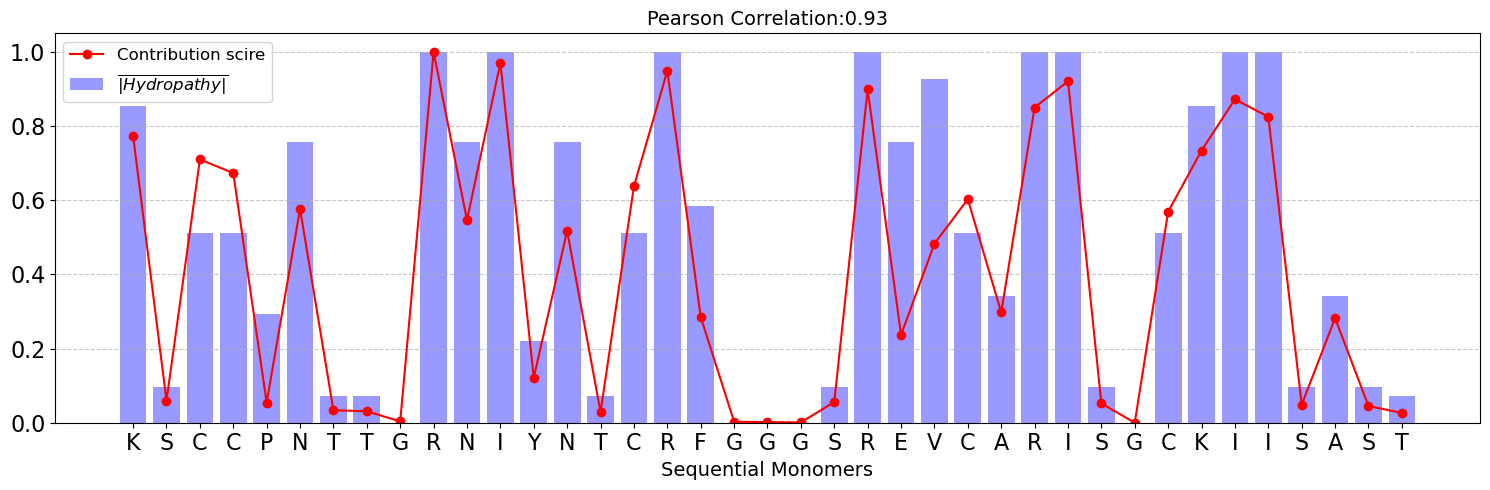

In [6]:
pcc = np.corrcoef(chosen_imp, actual_imp)[0,1]


# X-axis positions
x = np.arange(len(actual_aa))

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 5))

# Plot actual_imp as bars
ax.bar(x, actual_imp, color='blue', alpha=0.4, label=r'$\overline{| Hydropathy |}$')

# Plot chosen_imp as a line
ax.plot(x, chosen_imp, color='red', marker='o', label='Contribution scire')

# Add x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(actual_aa, fontsize=12)
ax.set_xlabel('Sequential Monomers', fontsize=14)
# ax.set_ylabel('Importance', fontsize=14)

# Add title and legend
# ax.set_title('Importance Comparison', fontsize=16)
ax.legend(fontsize=12)
ax.set_title(f'Pearson Correlation:{round(pcc,2)}', fontsize=14)
# Show grid for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# Show the plot
plt.tight_layout()
plt.show()

### Plotting overall absolute hydropathy versus mean contribution score across all test examples

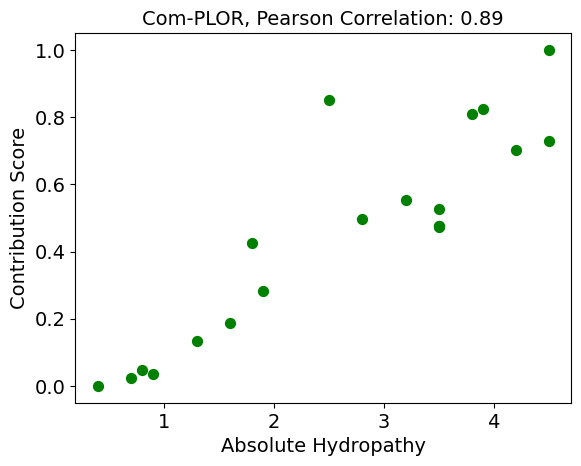

In [7]:
from scipy.stats import spearmanr
score = (score-min(score))/(max(score)-min(score))
pcc = np.corrcoef(hydro, score.T)[0,1]
spea = spearmanr(hydro, score.T)
spea = spea.correlation
# print(spea)
plt.scatter(hydro, score, s=50,color='green')
plt.title(f'Com-PLOR, Pearson Correlation: {round(pcc,2)}', fontsize=14)
plt.xlabel('Absolute Hydropathy', fontsize=14)
plt.ylabel('Contribution Score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(np.arange(0,1.2,0.2),fontsize=14)
plt.show()